In [2]:
import zarr
import xarray as xr
import matplotlib.pyplot as plt
import gzip
import pickle
import numpy as np

In [2]:
# %matplotlib notebook
from scipy import interpolate
from sympl import get_constant

Rd = get_constant('gas_constant_of_dry_air', 'J kg^-1 K^-1')
Cp =\
    get_constant('heat_capacity_of_dry_air_at_constant_pressure',
                 'J kg^-1 K^-1')
g=get_constant('gravitational_acceleration',
                 'm s^-2') 

p_std = np.arange(0.5, 9.6 ,0.5)[::-1]*10000
print(p_std[13])
def interpol1d(X, p):
    
    h,lt,ln=np.shape(p)
    out=np.zeros((len(p_std),lt,ln))
    
    for i in range(lt):
        for j in range(ln):
            f = interpolate.interp1d(p[:,i,j], X[:,i,j])
            out[:,i,j]=f(p_std)
            
    return out

lat1=17
lat2=19
lon1=24
lon2=52

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

print(lat_deg)

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

temp_clim=interpol1d(temp_clim, press_clim)
nwind_clim=interpol1d(nwind_clim, press_clim)

press_int=np.insert(p_std, 0, 101300)

# dz calculation

dz=Rd*temp_clim/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
z=dz.cumsum(axis=0)
geopot_clim=g*z

with gzip.open('/home/scratch/Abel_data/heat_indexv3', 'rb') as f:
    heat_index= pickle.load(f)

# iter=1
# e=heat_index[iter]

diaggeo_arr=[]
diagsur_arr=[]
diagwind_arr=[]

br=0
for e in heat_index:
    
#     br=br+1
#     if br==5:
#         break
    i=e[0]
    j=int(e[1])
    t0=e[2][0]-10
    
    if (t0>=0 and t0<365-21):  
        print(t0)

        dse_arr=[]
        surface_flux=[]
        temp_arr=[]

        dur=21
        diaggeo=np.zeros((dur,lon2-lon1))
        diagsur=np.zeros((dur,lon2-lon1))
        diagwind=np.zeros((dur,lon2-lon1))

        for k in range(dur):

            t=t0+k
            # .mean(dim='time')
            D=xr.open_zarr("/home/scratch/Abel_data/long_run2/run"+str(i)+"/year"+str(j),consolidated=False)
            temp=D['air_temperature'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            uwind=D['eastward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            nwind=D['northward_wind'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            press=D['air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            spress=D['surface_air_pressure'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            sens=D['surface_upward_sensible_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            latent=D['surface_upward_latent_heat_flux'][t].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
            
            temp=interpol1d(temp, press)
            nwind=interpol1d(nwind, press)
            
#             nwind=interpol1d(nwind, press)[0]
            nwind=nwind-nwind_clim
#             latent=(latent-latent_clim).values[:]
#             latent=xr.DataArray(data=latent, dims=["lat", "lon"])
#             latent=latent.assign_coords(lat=lat_deg[:,0],lon=lon_deg[0,:])

#             nwind=xr.DataArray(data=nwind, dims=["lat", "lon"])
#             nwind=nwind.assign_coords(lat=lat_deg[:,0],lon=lon_deg[0,:])

            press_int=np.insert(p_std, 0, 101300)

            # dz calculation

            dz=Rd*temp/g*np.log(press_int[:-1]/press_int[1:])[:,np.newaxis,np.newaxis]
            z=dz.cumsum(axis=0)
            geopot=(g*z-geopot_clim)[13]
            geopot=xr.DataArray(data=geopot, dims=["lat", "lon"])
            geopot=geopot.assign_coords(lat=lat_deg[:,0],lon=lon_deg[0,:])
            diaggeo[k,:]=geopot.interp(lat=40)
            
            nwind=(nwind-nwind_clim)[13]
            nwind=xr.DataArray(data=nwind, dims=["lat", "lon"])
            nwind=nwind.assign_coords(lat=lat_deg[:,0],lon=lon_deg[0,:])
            diagwind[k,:]=nwind.interp(lat=40)
            
            sens=(sens-sens_clim)
            sens=xr.DataArray(data=sens, dims=["lat", "lon"])
            sens=sens.assign_coords(lat=lat_deg[:,0],lon=lon_deg[0,:])
            diagsur[k,:]=sens.interp(lat=40)

        diaggeo_arr.append(diaggeo)
        diagwind_arr.append(diagwind)
        diagsur_arr.append(diagsur)
        
        
with gzip.open('/home/scratch/Abel_data/hovmoller_geopotv3', 'wb') as f:
    pickle.dump(diaggeo_arr, f)
with gzip.open('/home/scratch/Abel_data/hovmoller_sensv3', 'wb') as f:
    pickle.dump(diagsur_arr, f)
with gzip.open('/home/scratch/Abel_data/hovmoller_nwindv3', 'wb') as f:
    pickle.dump(diagwind_arr, f)

# diag=xr.DataArray(data=diag, dims=["time", "lon"])
# diag=diag.assign_coords(time=range(-10,-10+dur,1),lon=lon_deg[0,:])

# diag.plot.contour(levels=[-10,-5,5,10],colors='k')
# # diag.plot.contourf()

/home/data/miniconda3/lib/python3.8/site-packages/sympl/_core/dataarray.py:6: FutureWarning: xarray subclass DataArray should explicitly define __slots__
  class DataArray(xr.DataArray):


30000.0
[[40.46364818 40.46364818 40.46364818 40.46364818 40.46364818 40.46364818
  40.46364818 40.46364818 40.46364818 40.46364818 40.46364818 40.46364818
  40.46364818 40.46364818 40.46364818 40.46364818 40.46364818 40.46364818
  40.46364818 40.46364818 40.46364818 40.46364818 40.46364818 40.46364818
  40.46364818 40.46364818 40.46364818 40.46364818]
 [37.67308963 37.67308963 37.67308963 37.67308963 37.67308963 37.67308963
  37.67308963 37.67308963 37.67308963 37.67308963 37.67308963 37.67308963
  37.67308963 37.67308963 37.67308963 37.67308963 37.67308963 37.67308963
  37.67308963 37.67308963 37.67308963 37.67308963 37.67308963 37.67308963
  37.67308963 37.67308963 37.67308963 37.67308963]]
292
30
66
154
163
21
73
192
220
173
15
298
339
44
122
215
222
252
178
342
288
85
177
252
286
285
1
154
250
100
279
9
86
50
185
277
340
63
44
64
9
246
282
121
241
200
269
342
167
110
305
114
12
76
168
85
205
213
172
28
37
20
33
192
258
283
103
172
180
215
221
19
26
93
155
162
295
147
199
3
36
313


[[40.46364818 40.46364818 40.46364818 40.46364818 40.46364818 40.46364818
  40.46364818 40.46364818 40.46364818 40.46364818 40.46364818 40.46364818
  40.46364818 40.46364818 40.46364818 40.46364818 40.46364818 40.46364818
  40.46364818 40.46364818 40.46364818 40.46364818 40.46364818 40.46364818
  40.46364818 40.46364818 40.46364818 40.46364818]
 [37.67308963 37.67308963 37.67308963 37.67308963 37.67308963 37.67308963
  37.67308963 37.67308963 37.67308963 37.67308963 37.67308963 37.67308963
  37.67308963 37.67308963 37.67308963 37.67308963 37.67308963 37.67308963
  37.67308963 37.67308963 37.67308963 37.67308963 37.67308963 37.67308963
  37.67308963 37.67308963 37.67308963 37.67308963]]


<IPython.core.display.Javascript object>


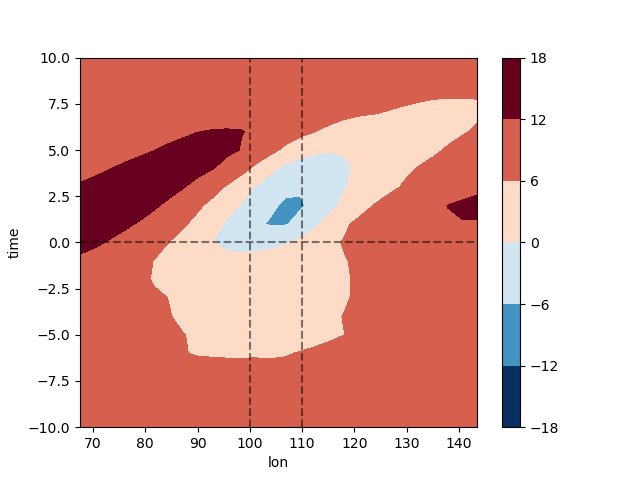

In [3]:
%matplotlib notebook

with gzip.open('/home/scratch/Abel_data/heat_index', 'rb') as f:
    heat_index= pickle.load(f)

with gzip.open('/home/scratch/Abel_data/hovmoller_sensv3', 'rb') as f:
    diag_arr=pickle.load(f)

dur=21

#######################################################################

lat1=17
lat2=19
lon1=24
lon2=52

common=xr.open_zarr("/home/scratch/Abel_data/long_run2/common",consolidated=False)
lat_rad=np.radians(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_rad=np.radians(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

lat_deg=(common['latitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]
lon_deg=(common['longitude']).sel(lat=range(lat1,lat2),lon=range(lon1,lon2)).values[:]

print(lat_deg)

lat_diff=lat_deg[0,0]-lat_deg[1,0]
lon_diff=lon_deg[0,1]-lon_deg[0,0]

Lx=np.radians(lon_diff)*6371*1000
Ly=np.radians(lat_diff)*6371*1000

clim=xr.open_zarr("/home/scratch/Abel_data/climatology_1000",consolidated=False)
temp_clim=clim['air_temperature'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
uwind_clim=clim['eastward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
nwind_clim=clim['northward_wind'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
press_clim=clim['air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
spress_clim=clim['surface_air_pressure'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
sens_clim=clim['surface_upward_sensible_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))
latent_clim=clim['surface_upward_latent_heat_flux'].sel(lat=range(lat1,lat2),lon=range(lon1,lon2))

sens=xr.DataArray(data=sens_clim, dims=["lat", "lon"])
sens=sens.assign_coords(lat=lat_deg[:,0],lon=lon_deg[0,:])

################################################################################

# diag=diag_arr[10]
diag=np.mean(diag_arr,axis=0)+sens.interp(lat=40).values[:]
# diag=np.mean(diag_arr,axis=0)
diag=xr.DataArray(data=diag, dims=["time", "lon"])
diag=diag.assign_coords(time=range(-10,-10+dur,1),lon=lon_deg[0,:])

# diag.plot.contour(levels=[-10,-5,5,10],colors='k')
diag.plot.contourf()
plt.axvline(100,linestyle='--',color='k',alpha=0.5)
plt.axvline(110,linestyle='--',color='k',alpha=0.5)
plt.axhline(0,linestyle='--',color='k',alpha=0.5)
# plt.title('Sensible heat flux')